### References: http://www.scholarpedia.org/article/Echo_state_network, Hoerzer et al. 2014 Cerebral Cortex; Kumar et al. 2022 Cerebral Cortex

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def assign_group_numberings(eeg_data):
    #Create group numberings
	initial_value = 1  
	repeat_count = 5  
	increment_value = 1  
	total_elements = np.shape(eeg_data)[0] 
	remainder = total_elements%5
	groups=[]


	for i in range (0,total_elements,repeat_count):
		if i == total_elements-(remainder):
				groups.extend([initial_value]*remainder)
		else:
				groups.extend([initial_value]*5)
		initial_value += increment_value

	return groups

In [3]:
# normalize eeg data
def scale_data(eeg_data):
    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    eeg_data = scaler.fit_transform(eeg_data.reshape(-1, eeg_data.shape[-1])).reshape(eeg_data.shape)


    return eeg_data

# shuffle data
def shuffle_arrays(A, B, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    # Generate a random permutation of indices for the first dimension
    perm = np.random.permutation(A.shape[0])
    
    # Apply the permutation to shuffle A and B
    A_shuffled = A[perm, ...]
    B_shuffled = B[perm, ...]
    
    return A_shuffled, B_shuffled



In [4]:
# load eeg data and labels
from scipy.signal import butter, lfilter
import scipy.io


num_trials = 1000
master_data = {}
master_labels = {}
subject_num = 6
num_eeg_channels = 73

# for 5-way classification
filename = "data/P"+str(subject_num)+'dataxepoch.mat'
reject = [1,3,8,11,13]



data = scipy.io.loadmat(filename)
keys = [x for x in data.keys() if "P" in x]


# create dictionary for each key for each participant
eeg_data = []

eeg_baseline = []


for i in range(len(keys)):
	data_sub = data[keys[i]][:,:,205:2000]
	baseline_data = data[keys[i]][:,:,0:204]
	# uncomment for erp-based features
	# b,a = butter(4, [0.1, 40], fs=2048, btype='band')
	# data_sub = lfilter(b, a, data_sub)
	
	eeg_data.extend(data_sub)
	eeg_baseline.extend(baseline_data)

eeg_data = np.asarray(eeg_data)
eeg_data = scale_data(eeg_data)


eeg_labels = np.concatenate((0*np.ones(np.shape(data[keys[0]])[0]),1*np.ones(np.shape(data[keys[1]])[0]),
							  2*np.ones(np.shape(data[keys[2]])[0]),3*np.ones(np.shape(data[keys[3]])[0]),
							  4*np.ones(np.shape(data[keys[4]])[0])))
eeg_labels = eeg_labels.astype(int).reshape(-1,1)

groups = assign_group_numberings(eeg_data)


eeg_shuff, label_shuff = shuffle_arrays(eeg_data, eeg_labels, seed=42)

In [ ]:
class ReservoirComputingNetwork:
    def __init__(self, input_size, reservoir_size, output_size, chaos=1.2, tau=50, dt=1, learning_rate=0.0001):
        self.tau = tau  # time constant
        self.alpha = dt/self.tau
        self.nin = input_size
        self.nrnn = reservoir_size
        self.nout = output_size
        self.cp = [1,0.1]  #connection probability
        self.lr = learning_rate
        self.w_in_scale = 0.1
        
        # Initialize weights
        winconn = np.random.uniform(-1, 1, (self.nrnn, self.nin)) * self.w_in_scale  # uniform dist [-1,1]
        winprob = np.random.choice([0, 1], (self.nrnn, self.nin), p=[1 - self.cp[0], self.cp[0]])
        self.w_in = np.multiply(winconn, winprob) # cater to different input connection probabilities

        connex = np.random.normal(0, np.sqrt(1 / (self.cp[1] * self.nrnn)), size=(self.nrnn, self.nrnn))
        prob = np.random.choice([0, 1], (self.nrnn, self.nrnn), p=[1 - self.cp[1], self.cp[1]])
        w_rec = chaos * np.multiply(connex, prob)  # initialise random network with connection probability
        w_rec *= (np.eye(self.nrnn) == 0)  # remove self recurrence
        self.w_rec = w_rec

        self.w_fb = np.random.uniform(-1, 1, (self.nrnn, self.nout)) 
        
        self.w_out = np.random.rand(output_size, reservoir_size) * 1/reservoir_size

    def reset(self,trial):
        np.random.seed(trial)
        self.state = np.random.rand(self.nrnn)*0.1
        self.output = np.random.rand(self.nout)*0.1

    
    def run(self, input_vector):
        # Update reservoir state using leaky integrator rule
        I = np.dot(self.w_in, input_vector)
        h = np.dot(self.w_rec, self.state)
        fb = np.dot(self.w_fb, self.output)
        self.state = (1.0 - self.alpha) * self.state + self.alpha * np.tanh(I + h + fb)
        
        # Compute output
        self.output = np.dot(self.w_out, self.state)
        return self.output
    
    def learn(self, predicted_output,target_output):
        # Simple delta rule (Gradient descent on the output weights)
        # Run network to get current output
        self.error = target_output - predicted_output
        
        # Update the output weights using the delta rule
        self.w_out += self.lr * np.outer(self.error, self.state)
        return self.error
    
 


In [ ]:
# modeltask setup
total_instruments = 5
trial_length = eeg_shuff.shape[2] # ms, change according to how long each trial was
dt = 1 # ms
total_trials = eeg_shuff.shape[0]
# test_trials = [1,5,90,50,150,300,467,540,664,720,890,990]  # trials in which classifier is not updated

ninputs = num_eeg_channels = eeg_shuff.shape[1]
nrnn = 2048  # can make it bigger, but 1024 is the smallest for this model
noutputs = total_instruments
tau = 50  # between 10 to 100, larger allows the model to integrate information over longer time horizon
chaos = 1.5
lr = 0.0001  # dont go higher than 0.01

reservoir = ReservoirComputingNetwork(input_size=ninputs, reservoir_size=nrnn, output_size=noutputs,chaos=chaos, tau=tau,learning_rate=lr)
init_wout = reservoir.w_out.copy()

In [7]:
# # plot difference in data distribution
# # ensure that different instruments elicit anti-correlated audio data, brain signals, EEG data

# eegs = np.zeros([total_instruments,  num_eeg_channels*trial_length*(total_trials//total_instruments)])
# res = np.zeros([total_instruments, trial_length*(total_trials//total_instruments), nrnn])


# f,ax = plt.subplots(2,6,figsize=(3*6,2*2))
# for instrument in range(total_instruments):

#     idx = (label_shuff == instrument)[:,0]
#     eegs[instrument] = eeg_shuff[idx].reshape(-1)


#     instrument_label = label_shuff[idx]

#     ax[0,instrument].hist(eegs[instrument])


#     x = eegs[instrument].reshape(-1, num_eeg_channels)
#     # reservoir.reset(0)
#     # for t in range(x.shape[0]):
#     #     _ = reservoir.run(x[t])
#     #     res[instrument, t] = reservoir.state

#     ax[0,instrument].set_title(f'Instrument {instrument}')

# corrs = np.zeros([total_instruments, total_instruments, 4])
# for d, data in enumerate([eegs, res]):
#     for i in range(total_instruments):
#         for j in range(total_instruments):
#             corrs[i,j,d] = np.corrcoef(data[i].reshape(-1), data[j].reshape(-1))[0,1]
#     im = ax[d,5].imshow(corrs[:,:,d])
#     plt.colorbar(im,ax=ax[d,5])

# ax[0,0].set_ylabel('EEG dist.')
# # ax[1,0].set_ylabel('RNN dist.')

# f.tight_layout()

In [ ]:
# sample code to load eeg_data and eeg_labels

from sklearn.model_selection import  train_test_split



train_trials, test_trials, train_labels, test_labels = train_test_split(
    eeg_shuff, label_shuff, test_size=0.33, random_state=42)

num_test_trials = len(test_trials)
num_train_trials = len(train_trials)

record_output = np.zeros([num_train_trials, trial_length, noutputs])
record_error = np.zeros([num_train_trials, trial_length, noutputs])

record_test_output = np.zeros([num_test_trials, trial_length, noutputs])
record_test_error = np.zeros([num_test_trials, trial_length, noutputs])



for trial in range(num_train_trials):
    # insert eeg data here
    data = train_trials[trial]
    instrument_class = train_labels[trial]
    ground_truth = np.eye(total_instruments)[instrument_class]

    # initialize reservoir dynamics at the start at each run
    reservoir.reset(trial)
    print(f'Trial {trial}, Instrument {instrument_class}')
    for time in range(trial_length):
        x_eeg = data[:,time]

        # predict classifier output
        pred = reservoir.run(x_eeg)

        # online learning to classify , if trial is in test_trials, do not change classifier weights/learn
        if trial+1 not in test_trials:
            error = reservoir.learn(pred, ground_truth)

        record_output[trial, time] = pred
        record_error[trial, time] = ground_truth - pred

for trial in range(num_test_trials):
    data = test_trials[trial]
    instrument_class = test_labels[trial]
    ground_truth = np.eye(total_instruments)[instrument_class]
    reservoir.reset(trial)
    print(f'Trial {trial}, Instrument {instrument_class}')
    for time in range(trial_length):
        x_eeg = data[:,time]

        # predict classifier output
        test_pred = reservoir.run(x_eeg)



        record_test_output[trial, time] = test_pred
        record_test_error[trial, time] = ground_truth - test_pred



Trial 0, Instrument [2]
Trial 1, Instrument [2]
Trial 2, Instrument [3]
Trial 3, Instrument [2]
Trial 4, Instrument [2]
Trial 5, Instrument [1]
Trial 6, Instrument [0]
Trial 7, Instrument [4]
Trial 8, Instrument [4]
Trial 9, Instrument [3]
Trial 10, Instrument [4]
Trial 11, Instrument [3]
Trial 12, Instrument [0]
Trial 13, Instrument [2]
Trial 14, Instrument [2]
Trial 15, Instrument [0]
Trial 16, Instrument [3]
Trial 17, Instrument [1]
Trial 18, Instrument [1]
Trial 19, Instrument [0]
Trial 20, Instrument [3]
Trial 21, Instrument [2]
Trial 22, Instrument [1]
Trial 23, Instrument [2]
Trial 24, Instrument [3]
Trial 25, Instrument [4]
Trial 26, Instrument [2]
Trial 27, Instrument [2]
Trial 28, Instrument [1]
Trial 29, Instrument [4]
Trial 30, Instrument [2]
Trial 31, Instrument [1]
Trial 32, Instrument [0]
Trial 33, Instrument [2]
Trial 34, Instrument [4]
Trial 35, Instrument [4]
Trial 36, Instrument [3]
Trial 37, Instrument [0]
Trial 38, Instrument [4]
Trial 39, Instrument [4]
Trial 40, 

In [ ]:
accuracy = np.mean(test_labels == np.argmax(record_test_output,axis=2),axis=1)



0.1942922258799696

Test classication Accuracy Before Training: 0.0, Chance is 0.2
Test classication Accuracy After Training: 0.8924791086350975


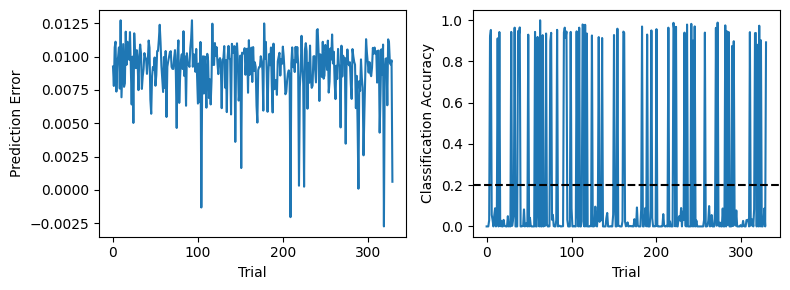

In [ ]:
f,ax = plt.subplots(1,2,figsize=(8,3))
error = np.mean(np.mean(record_test_error,axis=1),axis=1)
ax[0].plot(error)
ax[0].set_xlabel('Trial')
ax[0].set_ylabel('Prediction Error')

accuracy = np.mean(test_labels == np.argmax(record_test_output,axis=2),axis=1)
average_test_accuracy = np.mean(accuracy)

ax[1].plot(accuracy)
ax[1].set_xlabel('Trial')
ax[1].set_ylabel('Classification Accuracy')
ax[1].axhline(1/total_instruments,color='k',linestyle='--')

f.tight_layout()

before_test = accuracy[0]
after_test = accuracy[-1]
print(f'Test classication Accuracy Before Training: {before_test}, Chance is {1/total_instruments}')
print(f'Test classication Accuracy After Training: {after_test}')
print(f'Average Test Accuracy: {average_test_accuracy}')


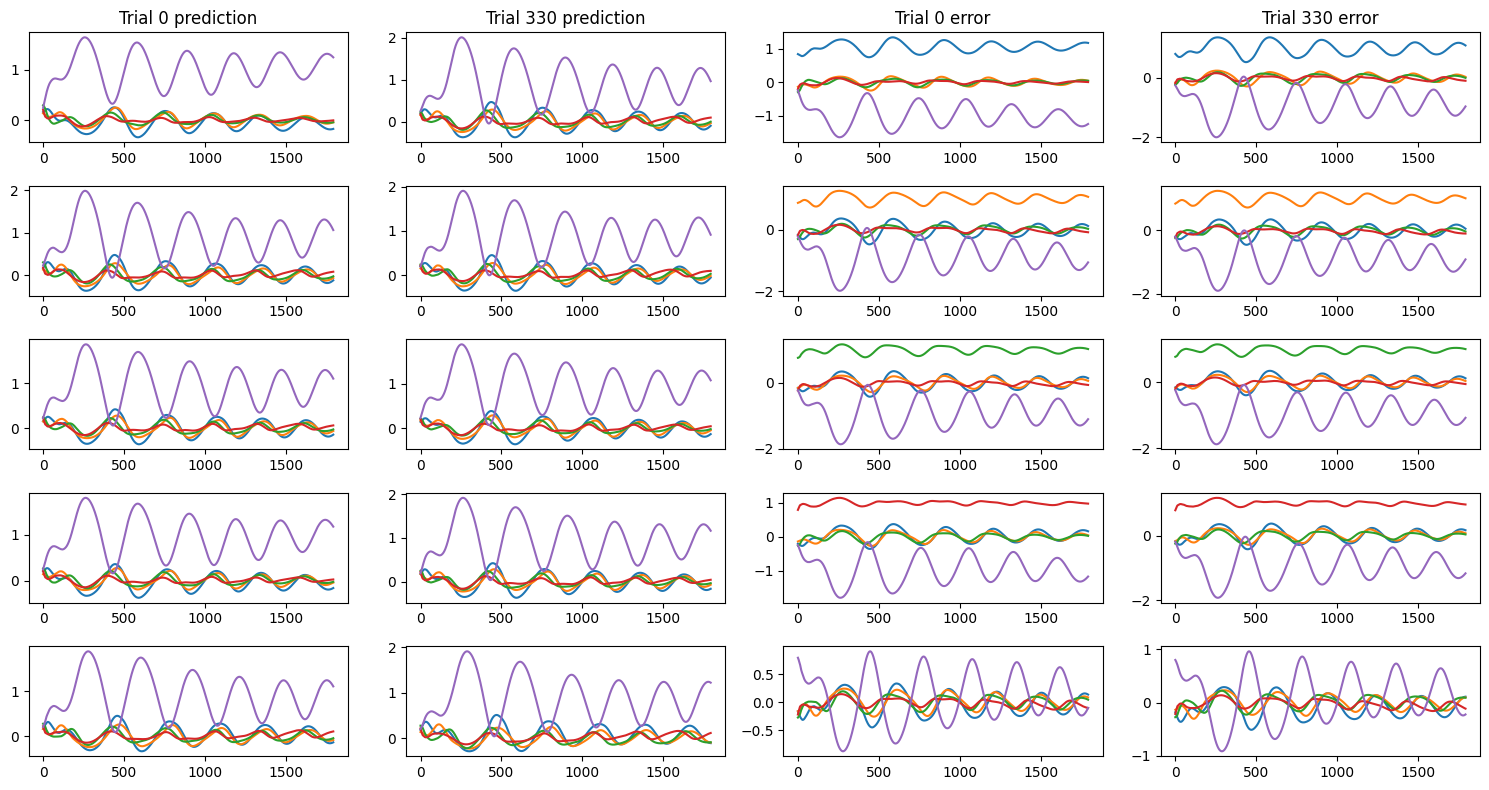

In [16]:
f,ax = plt.subplots(total_instruments,4,figsize=(3*total_instruments,2*4))

index = np.arange(num_test_trials)
for instrument in range(total_instruments):
    idx = index[test_labels[:,0]== instrument]

    ax[instrument, 0].plot(record_test_output[idx[0]])

    ax[instrument, 1].plot(record_test_output[idx[-1]])

    ax[instrument, 2].plot(record_test_error[idx[0]])

    ax[instrument, 3].plot(record_test_error[idx[-1]])

ax[0,0].set_title('Trial 0 prediction')
ax[0,1].set_title(f'Trial {num_test_trials} prediction')

ax[0,2].set_title('Trial 0 error')
ax[0,3].set_title(f'Trial {num_test_trials} error')

f.tight_layout()